# Tutorial V: Transfer Learning

<p>
Bern Winter School on Machine Learning, 2024<br>
Prepared by Mykhailo Vladymyrov and Matthew Vowels.
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will use the pretrained Inception model to build own image classifier. We will aslo learn how to save our trained models.

## 1. Load necessary libraries

In [24]:
colab = False # set to True is using google colab

In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
import shutil
import tarfile

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.hub import download_url_to_file
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from PIL import Image

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Download libraries

In [27]:
if colab:
    path = os.path.join(os.path.abspath('.')+'material.tgz')
    url = 'https://github.com/neworldemancer/BMLWS/raw/main/tut_files/tpub0320.tgz'
    # p = tf.keras.utils.get_file(path, url)
    # Download compressed file with torch utils

    download_url_to_file(url=url, dst=path)

    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

## 2. Transfer learning

We load first an inception model with pretrained weights, without the final classifier:

In [28]:
print(torch.hub.help('pytorch/vision:v0.7.0', 'inception_v3'))


    Inception v3 model architecture from
    `Rethinking the Inception Architecture for Computer Vision <http://arxiv.org/abs/1512.00567>`_.

    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.

    Args:
        weights (:class:`~torchvision.models.Inception_V3_Weights`, optional): The
            pretrained weights for the model. See
            :class:`~torchvision.models.Inception_V3_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.Inception3``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/inception.py>`

Using cache found in /Users/pbecerra/.cache/torch/hub/pytorch_vision_v0.7.0


In [29]:
# Load the Inception V3 model from the PyTorch torchvision hub
base_model = torch.hub.load('pytorch/vision:v0.7.0', 'inception_v3')

Using cache found in /Users/pbecerra/.cache/torch/hub/pytorch_vision_v0.7.0
/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [30]:
# Display the list of attributes and methods of the 'base_model'
dir(base_model)

['AuxLogits',
 'Conv2d_1a_3x3',
 'Conv2d_2a_3x3',
 'Conv2d_2b_3x3',
 'Conv2d_3b_1x1',
 'Conv2d_4a_3x3',
 'Mixed_5b',
 'Mixed_5c',
 'Mixed_5d',
 'Mixed_6a',
 'Mixed_6b',
 'Mixed_6c',
 'Mixed_6d',
 'Mixed_6e',
 'Mixed_7a',
 'Mixed_7b',
 'Mixed_7c',
 'T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks

In [31]:
base_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [32]:
# Create a SummaryWriter object for logging events to TensorBoard
writer = SummaryWriter('runs/inspect_inception_v3')

# Create a dummy input tensor 'xs' with dimensions (batch_size=1, channels=3, height=299, width=299)
xs = torch.zeros(1, 3, 299, 299)

# Add the computational graph of the 'base_model' to TensorBoard for visualization
writer.add_graph(base_model, xs)

# Close the SummaryWriter to ensure that all the events are written and the file is saved
writer.close()


In [33]:
#%tensorboard --logdir=runs/inspect_inception_v3

And build a new model using it:

In [34]:
def fc_head(in_features, n_classes):
    """
    Creates a fully connected (dense) head for the neural network.

    Parameters:
    - in_features (int): Number of input features to the fully connected layer.
    - n_classes (int): Number of output classes.

    Returns:
    - nn.Sequential: Sequential container for the fully connected head.
    """

    # Define a sequence of layers for the fully connected head
    fc_head_layers = nn.Sequential(
        nn.Linear(in_features, 64),   # Fully connected layer with in_features input and 64 output units
        nn.Sigmoid(),                 # Sigmoid activation function
        nn.Linear(64, n_classes)      # Fully connected layer with 64 input units and n_classes output units
    )

    return fc_head_layers


In [35]:
# Freeze the parameters of the base model to prevent them from being updated during training
for param in base_model.parameters():
    param.requires_grad = False

# Replace the existing fully connected (fc) layer with our custom 2-layer classification head
# Extract the number of input features from the original fc layer
in_features = base_model.fc.in_features

# Define the number of output classes for our classification task
n_classes = 2

# Create and replace the fc layer with our custom classification head
base_model.fc = fc_head(in_features, n_classes)

# Move the model to the specified device (GPU or CPU)
model = base_model.to(device)



In [36]:
# Define the loss function (Cross Entropy)
criterion = nn.CrossEntropyLoss()
# Define the Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
def get_predictions(logits):
    """
    Get class predictions from model logits.

    Parameters:
    - logits (torch.Tensor): Raw model logits before softmax activation.

    Returns:
    - torch.Tensor: Predicted class labels.
    """

    # No need to apply softmax, as softmax is a monotonic function.
    # Applying argmax directly on logits to get class predictions.
    _, predictions = torch.max(logits, dim=1)

    return predictions

In [38]:
def calculate_accuracy_batch(predictions, labels):
    """
    Calculate the number of correct predictions and total examples in a batch.

    Parameters:
    - predictions (torch.Tensor): Predicted class labels.
    - labels (torch.Tensor): True class labels.

    Returns:
    - tuple: A tuple containing the number of correct predictions and the total number of examples.
    """

    # Count the number of correct predictions by comparing predicted and true labels
    n_correct = torch.sum(predictions == labels).item()

    # Total number of examples in the batch
    n_total = len(labels)

    # Return a tuple containing the number of correct predictions and the total number of examples
    return n_correct, n_total


## 3. Dataset

The Inception network is trained on natural images: thigs we see around everyday, like sky, flowers, animals, building, cars.
It builds a hierarchy of features to describe what it sees.
These features can be used to quickly (re)train the model on different classes of objects. E.g. [here](https://www.tensorflow.org/tutorials/image_retraining) are more examples on transfer learning.

Here you will see that these features can even be used to detect things that are very different from natural images. Namely, we will try to use it to distinguish German text in an image from Italian text in an image. We will use 100 sample photos taken from 5 German and 5 Italian books (10 samples from each book).

In [47]:
# Define image transformations to be applied to each image in the dataset
image_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize each image to a uniform size of 299x299 pixels (needed to use Inception v3)

    transforms.ToTensor(),  # Convert the image to a PyTorch tensor

    # Normalize the image tensor with mean and standard deviation values commonly used for pre-trained models
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a PyTorch ImageFolder dataset by loading images from the 'ML3' folder and applying the defined transformations
dataset = datasets.ImageFolder('ML3', transform=image_transform)
dataset


Dataset ImageFolder
    Number of datapoints: 100
    Root location: ML3
    StandardTransform
Transform: Compose(
               Resize(size=(299, 299), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [48]:
# Visualise the final class labels (in this example, 'de' for german text and 'it' for italian text)
text_label = dataset.classes
print(text_label)

['de', 'it']


0 torch.Size([3, 299, 299]) tensor(-2.0837) tensor(2.6400) tensor(1.7154) tensor(1.2477)


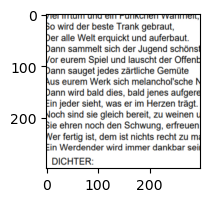

0 (299, 299, 3) 0.0 1.0 0.83515096 0.28198773


In [49]:
# Iterate through each image-label pair in the dataset
for image, label in dataset:
    # Print information about the image
    print(label, image.shape, image.min(), image.max(), image.mean(), image.std())

    # Convert the PyTorch tensor to a numpy array, transpose from CHW to HWC, and scale to the range [0, 1]
    image_numpy = image.cpu().numpy().transpose(1, 2, 0)
    image_numpy -= image_numpy.min(axis=(0, 1))
    image_numpy /= image_numpy.max(axis=(0, 1))

    # Display the image using matplotlib
    plt.figure(figsize=(2, 2))
    plt.imshow(image_numpy)
    plt.show()

    # Print information about the transformed image
    print(label, image_numpy.shape, image_numpy.min(), image_numpy.max(), image_numpy.mean(), image_numpy.std())

    # Break the loop after displaying the first image
    break


In [61]:
# Splitting the dataset into train and validation sets: 80% for training and 20% for validation

# Define the batch size for the datasets
batch_size = 10

# Use torch.utils.data.random_split to split the dataset into training and validation sets
# The first argument is the dataset to be split, and the second argument is a list representing the proportions
# Here, 80% of the data is allocated to the training set (dataset_tra), and 20% to the validation set (dataset_val)
dataset_tra, dataset_val = torch.utils.data.random_split(dataset, [0.8, 0.2])


Is this a good way to split the dataset? Why/Why not?

- not really. the split may not be balanced in size

In [63]:
# Extracting labels from the training dataset
labels_train = np.array([label for _, label in dataset_tra])

# Print the counts of occurrences for each class in the training dataset
print(f'n_class_0 = {np.sum(labels_train == 0)}, n_class_1 = {np.sum(labels_train == 1)}')


n_class_0 = 39, n_class_1 = 41


Rather than selecting the split at random, it's better to have a balanced (strtifed) training and validation sets

In [64]:
# Calculate the total number of samples in the dataset
n_samples = len(dataset)

# Extract labels from the entire dataset
labels = np.array([label for _, label in dataset])

# Split the dataset into training and validation sets using stratified sampling
# Stratified sampling ensures that the class distribution is maintained in both sets
idx_tra, idx_val = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=labels)

# Create training dataset using the Subset class with indices obtained for training
dataset_tra = torch.utils.data.Subset(dataset, idx_tra)

# Create validation dataset using the Subset class with indices obtained for validation
dataset_val = torch.utils.data.Subset(dataset, idx_val)


In [66]:
# Visualise the new split, as before

lbls = np.array([lbl for _, lbl in dataset_tra])
print(f'Training dataset: n_class_0 = {np.sum(lbls == 0)}, n_class_1 = {np.sum(lbls == 1)}')

lbls = np.array([lbl for _, lbl in dataset_val])
print(f'Validation dataset: n_class_0 = {np.sum(lbls == 0)}, n_class_1 = {np.sum(lbls == 1)}')

Training dataset: n_class_0 = 40, n_class_1 = 40
Validation dataset: n_class_0 = 10, n_class_1 = 10


Now we create the data loaders. A data loader is a utility in PyTorch that provides an efficient way to load and iterate over datasets during training or evaluation in machine learning models. It is part of the torch.utils.data module.

Key features and purposes of a data loader include:

- Batch Loading: Data loaders divide a dataset into batches, allowing you to load and process a subset of the data at a time. This is crucial for training deep learning models efficiently, especially when dealing with large datasets.

- Shuffling: During training, it is common to shuffle the data within each epoch to prevent the model from learning the order of the samples. Shuffling helps improve the generalization of the model.

- Parallelism: Data loaders can automatically parallelize the data loading process, enabling faster loading and preprocessing when working with multi-core systems.

- Iterability: Data loaders are iterable, allowing you to use them in a loop for iterating over batches of data. This is essential for training deep learning models in mini-batch fashion.

In [67]:
# Create data loaders for training and validation datasets.

# Define the batch size for loading data
batch_size = 10

# Create a DataLoader for the training dataset with batch_size, enabling shuffling for each epoch
loader_tra = torch.utils.data.DataLoader(dataset_tra, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the validation dataset with batch_size, without shuffling
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


Let's see a sample:

torch.Size([10, 3, 299, 299]) tensor(-2.1179) tensor(2.6400) tensor(1.8294) tensor(1.1059)


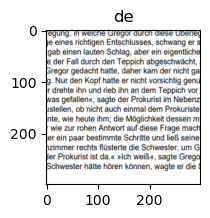

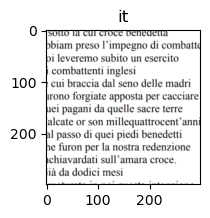

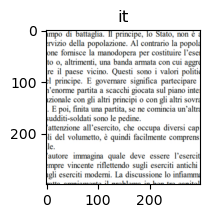

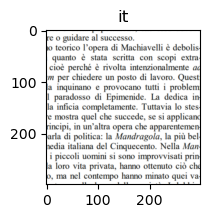

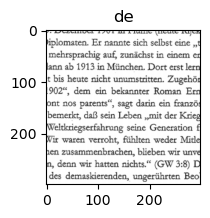

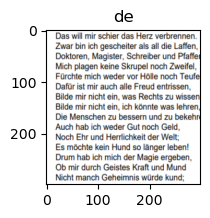

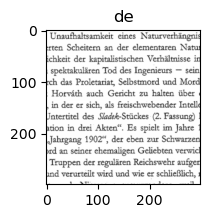

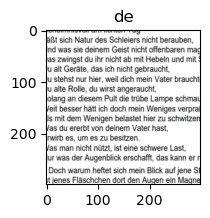

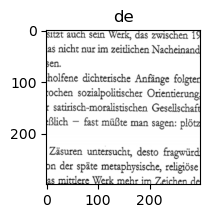

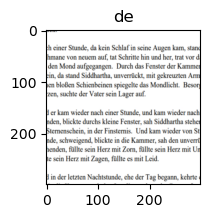

In [69]:
# Get a batch from the training dataset using the DataLoader
ims, lbls = next(iter(loader_tra))

# Print information about the batch of images
print(ims.shape, ims.min(), ims.max(), ims.mean(), ims.std())

# Visualize each image in the batch along with its corresponding label
for im, lbl in zip(ims, lbls):
    # Convert the PyTorch tensor to a NumPy array, transpose from CHW to HWC, and scale to the range [0, 1]
    im_numpy = im.cpu().numpy().transpose(1, 2, 0)
    im_numpy -= im_numpy.min(axis=(0, 1))
    im_numpy /= im_numpy.max(axis=(0, 1))

    # Plot the image with its label
    plt.figure(figsize=(2, 2))
    plt.imshow(im_numpy)
    plt.title(text_label[lbl])  # Assuming 'text_label' is a dictionary mapping labels to text descriptions
    plt.show()


In [70]:
# Forward pass: Pass the batch of images through the neural network model on the specified device and save in 'res' variable
res = model(ims.to(device))

In [71]:
type(res)

torchvision.models.inception.InceptionOutputs

In [72]:
res

InceptionOutputs(logits=tensor([[-0.1962, -0.3526],
        [-0.2612, -0.4677],
        [-0.2435, -0.4044],
        [-0.1710, -0.4361],
        [-0.1653, -0.4599],
        [-0.2149, -0.3738],
        [-0.2170, -0.3994],
        [-0.1881, -0.3802],
        [-0.1560, -0.4328],
        [-0.1778, -0.3766]], grad_fn=<AddmmBackward0>), aux_logits=tensor([[-0.0260,  0.0018, -0.0169,  ...,  0.0385,  0.0188, -0.0146],
        [ 0.0042,  0.0364,  0.0030,  ...,  0.0326,  0.0310, -0.0385],
        [-0.0060,  0.0323, -0.0221,  ...,  0.0118,  0.0151, -0.0251],
        ...,
        [ 0.0124,  0.0427, -0.0205,  ...,  0.0308, -0.0092, -0.0369],
        [ 0.0424,  0.0513, -0.0236,  ...,  0.0002,  0.0307, -0.0426],
        [-0.0133,  0.0360, -0.0032,  ...,  0.0348,  0.0144, -0.0124]]))

In [73]:
logits = res.logits
logits.shape

torch.Size([10, 2])

## 4. Training

The training is similar to what we saw previously.

Since the Inception model is big, this will take a while, even if we use GPUs. On your laptop CPU this would probably take ~15 times longer. And we are not even training the whole Inception model but just the small layer on top + a very small dataset!

We will use callback to save checkpoints on each iteration of training. They contain values of trainable variables.

In [74]:
def train(model, train_loader, criterion, optimizer):
    """
    Function to perform one training epoch on the provided model.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    criterion : torch.nn.modules.loss._Loss
        Loss function used for training.
    optimizer : torch.optim.Optimizer
        Optimization algorithm for updating model parameters.

    Returns:
    --------
    float, float
        Tuple containing the average loss and accuracy for the epoch.
    """

    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the running loss
    n_correct_running = 0  # Initialize the running count of correctly predicted samples
    n_samples_running = 0  # Initialize the running count of total samples

    for images, labels in train_loader:
        images = images.to(device)  # Move images to the specified device (GPU or CPU)
        labels = labels.to(device)  # Move labels to the specified device

        optimizer.zero_grad()  # Reset gradients

        # Forward pass: compute logits using the model
        logits = model(images).logits

        # Compute the loss using the specified criterion
        loss = criterion(logits, labels)

        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters with gradients

        # Calculate accuracy for the batch and update running counts
        n_correct, n_samples = calculate_accuracy_batch(get_predictions(logits), labels)
        n_correct_running += n_correct
        n_samples_running += n_samples

        running_loss += loss.item()  # Update the running loss

    n = len(train_loader)
    
    # Calculate and return the average loss and accuracy for the epoch
    return running_loss / n, n_correct_running / n_samples_running


In [ ]:
def validate(model, val_loader, criterion):
    """
    Function to perform model validation on the provided validation dataset.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be validated.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    criterion : torch.nn.modules.loss._Loss
        Loss function used for validation.

    Returns:
    --------
    float, float
        Tuple containing the average loss and accuracy for the validation.
    """

    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0  # Initialize the running loss
    n_correct_running = 0  # Initialize the running count of correctly predicted samples
    n_samples_running = 0  # Initialize the running count of total samples

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)  # Move images to the specified device (GPU or CPU)
            labels = labels.to(device)  # Move labels to the specified device

            # Forward pass: compute logits using the model
            logits = model(images)

            # Compute the loss using the specified criterion
            loss = criterion(logits, labels)

            # Calculate accuracy for the batch and update running counts
            n_correct, n_samples = calculate_accuracy_batch(get_predictions(logits), labels)
            n_correct_running += n_correct
            n_samples_running += n_samples
            running_loss += loss.item()  # Update the running loss

    n = len(val_loader)
    
    # Calculate and return the average loss and accuracy for the validation
    return running_loss / n, n_correct_running / n_samples_running


In [75]:
def train_model(model, criterion, optimizer, n_epochs, train_loader, val_loader, save_path):
    """
    Function to train a neural network model over multiple epochs.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be trained.
    criterion : torch.nn.modules.loss._Loss
        Loss function used for training and validation.
    optimizer : torch.optim.Optimizer
        Optimization algorithm for updating model parameters.
    n_epochs : int
        Number of training epochs.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    save_path : str
        Path to save the trained model and training history.

    Returns:
    --------
    dict
        Dictionary containing the training history.
    """

    os.makedirs(save_path, exist_ok=True)  # Create the directory for saving the model and history

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch': []}

    for epoch in range(n_epochs):
        # Perform training and validation for each epoch
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Update the history dictionary with current epoch results
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch'].append(epoch)

        # Save the model and training history at the end of each epoch
        save_dict = {'epoch': epoch,
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'history': history,
                     }
        torch.save(save_dict, os.path.join(save_path, f'model_epoch_{epoch:03d}.pth'))

        # Print the training and validation metrics for the current epoch
        print(f'Epoch {epoch+1}/{n_epochs} | '
              f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f} | '
              f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')

    return history


In [76]:
def plot_history(history):
    """
    Function to plot the training and validation history.

    Parameters:
    -----------
    history : dict
        Dictionary containing training and validation metrics for each epoch.
    """

    # Create a figure with two subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot training and validation loss in the first subplot
    axs[0].plot(history['epoch'], history['train_loss'])
    axs[0].plot(history['epoch'], history['val_loss'])
    axs[0].legend(('training loss', 'validation loss'), loc='lower right')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Loss')

    # Plot training and validation accuracy in the second subplot
    axs[1].plot(history['epoch'], history['train_acc'])
    axs[1].plot(history['epoch'], history['val_acc'])
    axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training and Validation Accuracy')

    # Show the plot
    plt.show()


In [77]:
save_path = 'TL_1'  # Define the directory to save the trained model and training history
n_epochs = 70        # Number of training epochs

# Train the model using the specified parameters
history = train_model(model, criterion, optimizer, n_epochs, loader_tra, loader_val, save_path)


Epoch 1/70 | train_loss: 0.7399, train_acc: 0.5125 | val_loss: 1.3769, val_acc: 0.5000
Epoch 2/70 | train_loss: 0.6899, train_acc: 0.5250 | val_loss: 0.8904, val_acc: 0.5000
Epoch 3/70 | train_loss: 0.6835, train_acc: 0.5625 | val_loss: 0.6814, val_acc: 0.5000
Epoch 4/70 | train_loss: 0.6052, train_acc: 0.5875 | val_loss: 0.7316, val_acc: 0.5000
Epoch 5/70 | train_loss: 0.6399, train_acc: 0.5625 | val_loss: 0.6878, val_acc: 0.4500
Epoch 6/70 | train_loss: 0.5905, train_acc: 0.6250 | val_loss: 0.6979, val_acc: 0.4500
Epoch 7/70 | train_loss: 0.6666, train_acc: 0.6125 | val_loss: 0.7049, val_acc: 0.6000
Epoch 8/70 | train_loss: 0.5748, train_acc: 0.6875 | val_loss: 0.6801, val_acc: 0.4500
Epoch 9/70 | train_loss: 0.5863, train_acc: 0.6375 | val_loss: 0.6867, val_acc: 0.6500
Epoch 10/70 | train_loss: 0.5020, train_acc: 0.8000 | val_loss: 0.6846, val_acc: 0.5500
Epoch 11/70 | train_loss: 0.6008, train_acc: 0.6875 | val_loss: 0.6892, val_acc: 0.5500
Epoch 12/70 | train_loss: 0.5652, train_a

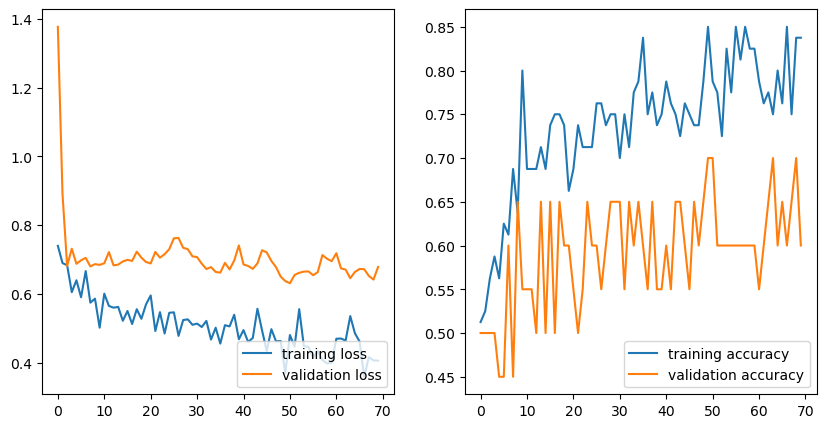

In [78]:
plot_history(history)

We see that training accuracy hits 100% quickly. Why do you think it happens? Consider that loss keeps decreasing.
Also on such a small dataset our model overfits.

## 5. Load trained variables

If we have the model already created we can easily load the saved training variables values from a checkpoint:

In [79]:
test_epochs = [0, 5, 11, 24, 69]  # List of epochs for validation testing
for ep in test_epochs:
    # Load the saved model and training history for the specified epoch
    d = torch.load(os.path.join(save_path, f'model_epoch_{ep:03d}.pth'))

    # Extract the model state dictionary from the loaded data
    model_state_dict = d['model_state_dict']

    # Load the model's parameters with the saved state
    model.load_state_dict(model_state_dict)

    # Perform validation on the loaded model for the specified epoch
    loss, acc = validate(model, loader_val, criterion)

    # Print the validation results for the specified epoch
    print(f'Epoch {ep} | val_loss: {loss:.4f}, val_acc: {acc:.4f}')


Epoch 0 | val_loss: 1.3769, val_acc: 0.5000
Epoch 5 | val_loss: 0.6979, val_acc: 0.4500
Epoch 11 | val_loss: 0.7218, val_acc: 0.5500
Epoch 24 | val_loss: 0.7303, val_acc: 0.6000
Epoch 69 | val_loss: 0.6785, val_acc: 0.6000


## 6. Saving for inference.

In pytorch it's easy to save a model for inference:

In [80]:
# Export the model for inference
torch.save(model, 'inference_model.pth')

## 7. Inference

In [82]:
loaded_model = torch.load('inference_model.pth')
loaded_model = loaded_model.to(device)
loaded_model.eval();  # set the model to inference (evaluation) mode

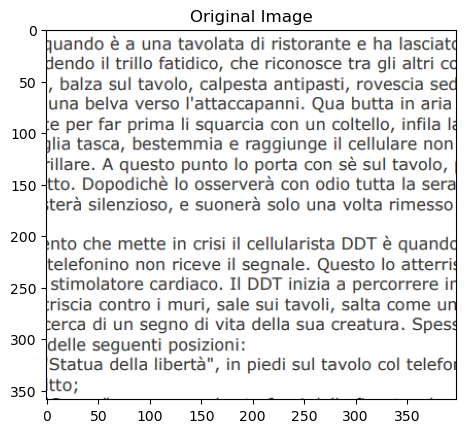

In [86]:
# Load an image for inference
im = Image.open('ML3/it/1_1.jpg')

# Display the original image
plt.imshow(im)
plt.title('Original Image')
plt.show()

In [87]:
# Apply the same transformations used during training to convert the image to a tensor
im_tensor = image_transform(im)

# Add a batch dimension and move the tensor to the specified device
im_tensor = im_tensor.unsqueeze(0).to(device)

# Print the shape of the resulting tensor
print(im_tensor.shape)

torch.Size([1, 3, 299, 299])


In [88]:
# Perform inference on the loaded model
with torch.no_grad():
    # Get logits from the loaded model
    logits = loaded_model(im_tensor)

    # Apply softmax to obtain class probabilities
    probs = F.softmax(logits, dim=1)

    # Get the predicted class using the get_predictions function
    pred = get_predictions(logits)

# Convert probabilities and predictions to numpy arrays
probs = probs.cpu().numpy()[0]  # Only one element in the batch
pred = pred.cpu().numpy()[0]

# Print the probability and predicted class label
print(f'Probability: {probs[pred]:.4f}, Predicted Class: {text_label[pred]}')

Probability: 0.9230, Predicted Class: it


## 8. Improving the results

Often, as in this sample we don't have anough labeled data in hand. We need to use it as efficient as possible.
One way to do it is to aply training data augmentation: we can slightly distort it, e.g. rescale, to effectively multiply the dataset.

We will generate rescaled images, minimum - to have smaller dimensions equal 256, maximum - 130%. Let's define a function which will do this job:

In [89]:
# Define a series of image transformations using transforms.Compose
image_transform = transforms.Compose([
    # Resize the input images to a fixed size of 299x299 pixels
    transforms.Resize((299, 299)),
    
    # (Optional) Add additional data augmentation transforms if needed, such as RandomCrop
    # Uncomment the following lines if you want to apply random crop during training
    # transforms.RandomCrop(512, pad_if_needed=True, fill=255),
    # transforms.RandomCrop(299),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the pixel values of the image using mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create a PyTorch ImageFolder dataset from the 'ML3' folder, applying the specified transformations
dataset = datasets.ImageFolder('ML3', transform=image_transform)


0 torch.Size([3, 299, 299]) tensor(-2.0837) tensor(2.6400) tensor(1.7154) tensor(1.2477)


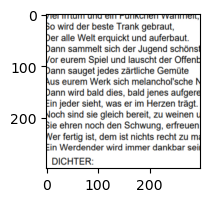

In [90]:
for im, lbl in dataset:
    print(lbl, im.shape, im.min(), im.max(), im.mean(), im.std())

    # convert tensor to numpy array, transpose from CHW to HWC and scale to range [0, 1]
    im_numpy = im.cpu().numpy().transpose(1,2,0)
    im_numpy -= im_numpy.min(axis=(0,1))
    im_numpy /= im_numpy.max(axis=(0,1))

    plt.figure(figsize=(2,2))
    plt.imshow(im_numpy)
    plt.show()
    break

In [91]:
# Get the total number of samples in the dataset
n_samples = len(dataset)

# Extract labels for all samples in the dataset
lbls = np.array([lbl for _, lbl in dataset])

# Split the indices into training and validation sets using stratified sampling
# The stratify parameter ensures that the class distribution is preserved in both sets
idx_tra, idx_val = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=lbls)

# Create subsets of the original dataset for training and validation using the obtained indices
dataset_tra = torch.utils.data.Subset(dataset, idx_tra)
dataset_val = torch.utils.data.Subset(dataset, idx_val)

In [92]:
# create data loaders
loader_tra = torch.utils.data.DataLoader(dataset_tra, batch_size=batch_size, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [93]:
# Load the Inception v3 model from the PyTorch vision library
base_model = torch.hub.load('pytorch/vision:v0.7.0', 'inception_v3')

# Freeze the parameters of the base model to prevent them from being updated during training
for param in base_model.parameters():
    param.requires_grad = False

# Replace the existing fully connected (fc) layer with a custom 2-layer classification head
in_features = base_model.fc.in_features
n_classes = 2
base_model.fc = fc_head(in_features, n_classes)

# Move the model to the specified device (e.g., GPU) for accelerated computation
model_aug = base_model.to(device)

# Define the loss function for classification tasks
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) for updating the model parameters during training
optimizer = optim.Adam(model_aug.parameters(), lr=0.001)

Using cache found in /Users/pbecerra/.cache/torch/hub/pytorch_vision_v0.7.0
/Users/pbecerra/.pyenv/versions/anaconda3-2023.07-2/envs/CAS/lib/python3.11/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
save_path = 'TL_2'

n_epochs=100

history = train_model(model_aug, criterion, optimizer, n_epochs, loader_tra, loader_val, save_path)

In [ ]:
plot_history(history)

We had a REEEALLY small dataset for such a complicated task. Does it really generalize? mb it just memorizes all the images we fed into it? Lets perform a test. `w1.PNG` and `w2.PNG` are text screenshots from wikipedia in [Italian](https://it.wikipedia.org/wiki/Apprendimento_automatico) and [German](https://de.wikipedia.org/wiki/Maschinelles_Lernen).

## 9. Exercise 1

In [ ]:
# load images
im_wiki_1 = plt.imread('ML3/w1.jpg')
im_wiki_2 = plt.imread('ML3/w2.jpg')

visualize the samples and perform inference

In [ ]:
...

## 10. Excercises

Do in 4 groups (35 min), in the end present results (2 min/group)

### Option 1.

In the situation when the model is likely to overfit, final performance would especially depend on the training datasets variety.

* Experiment with changes in aspect ratio and scale, using, e.g.
  `transforms.RandomResizedCrop(299, scale=(0.5, 2.0), ratio=(0.7, 1.3))` instead of the `transforms.RandomCrop`.
* Which other augmentations would make sense for the text data?
* Experiment and compare resulting best validation performance and number of epochs until the best validation accuracy.


### Option 2.

In the situation when the model is likely to overfit, final performance would especially depend on the learning rate.

* Plot the best validation accuracy vs learning rate.
* Plot the number of epochs until the best validation accuracy vs learning rate.

Test learning rates within +/- 1.5 orders of magnitude, i.e. from 30 times smaller to 30 times larger learning rates, than the current one.

Get 3 replicates.

### Option 3.

In the situation when the model is likely to overfit, final performance would especially depend on the model's architecture.

* Plot the best validation accuracy vs width of the first dense layer.
* Plot the number of epochs until the best validation accuracy vs width.

Test number of features in the first dense layer between 8 and 4096.

Get 3 replicates.

### Option 4.

We tested one model for the backbone of transfer learning. Try other ones (at least 3): https://pytorch.org/vision/stable/models.html.


* Plot the best validation accuracy vs model.
* Plot the number of epochs until the best validation accuracy vs model.
* Does any model generalize to wiki data?

Run 3 replicates for each model. Input size might vary for different models, adjust the crop size accordingly in parameters to `prepare_training_img`.

